## This is a notebook for the validation of GBA-centrality-PR

It consists of four parts:
- **Part I: Leave-one-out validation**

    This is a comparison between the distribution of scores for left-out proteins with the distribution of scores for all proteins in the interactome. We compare the two distributions using a statistical test (Wilcoxon rank-sum) and calculate the p-value.

- **Part II: Tissue-enrichment validation**

    This is a comparison between the ratio of predicted causal proteins enriched in the tissue with the ratio of all proteins enriched in the tissue. We compare the two ratio using a statistical test (Fisher exact) and calculate the p-value.

- **Part III: Contributions to scores at various distances**

    This is an analysis of contributions to the scores of all proteins from the seed proteins at distance 1 to 10.

- **Part IV: Robustness**

    This is a comparison between the lists of top 10% of highest-scoring genes generated with the new interactome (19/09/2024) vs the old interactome (15/01/2024). We hypothesize that the method is robust, therefore the two lists should be similar, even though the interactomes differ in the number of proteins and interactions. To determine the ovelap between the two lists, we compare then lists with a statistical test (Wilcoxon rank-sum) and calculate the p-value.

In [40]:
import sys

import scipy
import numpy

import matplotlib.pyplot
import matplotlib_venn
import seaborn

sys.path.append("../scripts")
import utils

In [116]:
def parse_scores(scores_file):
    '''
    Loads the scores generated with GBA_centrality_PR.py
    Returns a dictionary: key=ENSG, value=score
    '''
    results = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            results[ENSG] = float(score)

    return results

In [42]:
def parse_leave_one_out(leave_one_out_file):
    '''
    Loads the scores for left-out proteins generated with leave_one_out.py
    Returns a dictionary: key=ENSG, value=score
    '''
    results_left_out = {}

    with open(leave_one_out_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            results_left_out[ENSG] = float(score)
        
    return results_left_out

In [43]:
def geneName_to_ENSG(genes_file):
    '''
    Loads a TSV file with columns: geneName\tENSG
    Returns a dictionary: key=geneName, value=ENSG
    '''
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

In [44]:
def ENSG_to_geneName(genes_file):
    '''
    Loads a TSV file with columns: geneName\tENSG
    Returns a dictionary: key=ENSG, value=geneName
    '''
    ENSGs = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        ENSGs[ENSG] = gene_name
    
    return ENSGs

In [45]:
def intersection(list_1, list_2):
    '''
    Returns a list with common elements for two lists
    '''
    return list(set(list_1) & set(list_2))

In [46]:
def take_top_percent(list, x):
    '''
    Finds the top x% of values in a list
    Returns: 
    - top: list with top x% of values
    - rest list with the rest of values
    '''
    num_elements = int(len(list) * x/100)
    num_elements = max(num_elements, 1)

    top = list[:num_elements]
    rest = list[num_elements:]
    
    return top, rest

### Set parameters and paths

In [82]:
'''Set parameters with which the GBA_centrality_PR.py was run'''
PHENOTYPE = "MMAF" # to choose: MMAF, NOA, DILCARD, HYPCARD, BC (breast cancer), CC (colon cancer)
ALPHA = 0.5
D_MAX = 10

TISSUE = "testis"
# TISSUE = "breast"
# TISSUE = "colon"
# TISSUE = "heart"

In [83]:
alpha = str(ALPHA).replace('.', '')

In [84]:
INTERACTOME_PATH = "../input/Interactome_human.sif"
CANONICAL_GENES_PATH = "../input/canonicalGenes.tsv"

RESULTS_PATH = f"../../output/{PHENOTYPE}/alpha{alpha}_d{D_MAX}/scores.tsv"
LEAVE_ONE_OUT_PATH = f"../../output/{PHENOTYPE}/alpha{alpha}_d{D_MAX}/scores_leave_one_out.tsv"

In [85]:
'''Data and parameters for Part II: Tissue-enrichment validation'''
GTEX_DATA_PATH = f"E-MTAB-5214-query-results-{TISSUE}-ratio.tpms.tsv"

PRED_CAUSAL_DEFINITION = 10 # [%]
TISSUE_DEFINITION = 10 # [%]

In [120]:
'''Data and parameters for Part III: Contributions to scores at various distances'''
CONTRIBUTIONS_DIR = "./contributions_at_distances/"

In [122]:
'''Data and parameters for Part IV: Robustness'''
INTERACTOME_OLD_PATH = "../input/Interactome_human_15012024.sif"
RESULTS_OLD_PATH = f"../../output/Interactome_human_15012024/{PHENOTYPE}/alpha{alpha}_d{D_MAX}/scores.tsv"

In [87]:
'''Set path for output figures'''
FIGURES_DIR = "/home/kubicaj/workspace/Interactome-TIMC/dev/figures/"

### Load data

In [108]:
'''Parse interactome'''
interactome = utils.parse_interactome(interactome_file=INTERACTOME_PATH)
print(f"proteins: {len(interactome.nodes())}, interactions: {len(interactome.edges())}")

proteins: 14735, interactions: 91526


In [109]:
'''Load GBA centrality scores and leave-one-out results, then sort them'''
results = parse_scores(RESULTS_PATH)
results_leave_one_out = parse_leave_one_out(LEAVE_ONE_OUT_PATH)

results_sorted = sorted(results.keys(), key=lambda item: results[item], reverse=True)
results_leave_one_out = sorted(results_leave_one_out.keys(), key=lambda item: results_leave_one_out[item], reverse=True)

scores_sorted = [results[node] for node in results_sorted]
scores_leave_one_out_sorted = [results[node] for node in results_leave_one_out]

In [104]:
'''Load data for conversions between gene names and ENSGs'''
ENSGs = ENSG_to_geneName(CANONICAL_GENES_PATH)
gene_names = geneName_to_ENSG(CANONICAL_GENES_PATH)

In [110]:
'''Get top 10 high-scoring genes'''
for gene in results_sorted[:10]:
    print(ENSGs[gene])

CCDC66
C20orf96
CDX2
C9orf153
TTC29
TPGS1
TYMP
PLEKHG1
ONECUT3
RTTN


### Part I: Leave-one-out validation

In [115]:
'''Check if the distribution of scores for left-out proteins is greater than the distribution of scores for all proteins in the interactome'''
_, p_val = scipy.stats.ranksums(scores_leave_one_out_sorted, scores_sorted, alternative='greater')
p_val = '{:.2e}'.format(p_val)
print(f"p-value = {p_val}")

p-value = 3.76e-03


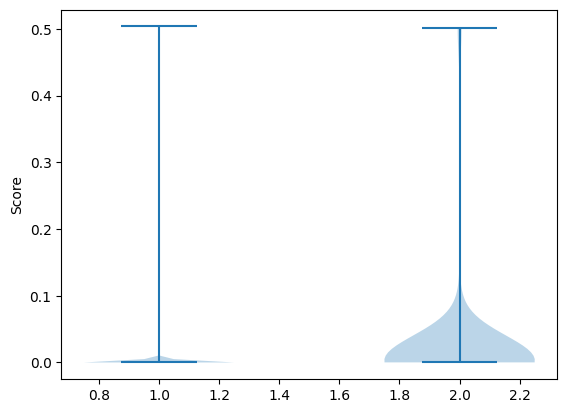

In [129]:
fig, ax = matplotlib.pyplot.subplots()
ax.set_ylabel("Score")
labels = ["Proteins in interactome\n(excluding causal)", "Left-out proteins"]

fig = ax.violinplot([scores_sorted, scores_leave_one_out_sorted])

# matplotlib.pyplot.ylim(0, 0.01)

In [114]:


seaborn.boxplot(data=[scores_sorted, scores_leave_one_out_sorted], x='group', y='score', hue='group', palette=['#2E78D2', '#FF7043'])

matplotlib.pyplot.title(f"Leave-one-out validation\n{PHENOTYPE}\n{ALPHA},\n{D_MAX}\n{p_val}", weight='bold', fontsize=12)
matplotlib.pyplot.ylabel("Score")
matplotlib.pyplot.xlabel("")
matplotlib.pyplot.ylim(0, 0.01)

phenotype = MMAF 
alpha = 0.5 
d = 10


TypeError: Data source must be a DataFrame or Mapping, not <class 'list'>.

In [113]:
'''Save figure for publication'''
matplotlib.pyplot.title(f"Leave-one-out validation\n{PHENOTYPE}", weight='bold', fontsize=12)
matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_leave_one_out", dpi=1000)

'Save figure for pubication'

### Part II: Tissue-enrichment (GTEx): "Are tissue-specific genes significantly enriched in the predicted causal genes?"

In [23]:
results_sorted = sorted(results.keys(), key=lambda item: results[item], reverse=True)

scores_sorted = [results[node] for node in results_sorted]

In [24]:
# get top PRED_CAUSAL_DEFINITION[%] of highest-scoring genes from New centrality
pred_causal, non_pred_causal = take_top_percent(results_sorted, PRED_CAUSAL_DEFINITION)

In [25]:
# load tissue expression from grexome-TIMC-Secondary-interactome/GTEX_Data
GTEx_tissue = {}

with open(GTEX_DATA_PATH) as f:
    # skip header
    for _ in range(5):
        next(f)
    for line in f:
        split_line = line.rstrip().split('\t')

        ENSG, tissue_ratio, *_ = split_line

        if ENSG in interactome.nodes():
            GTEx_tissue[ENSG] = float(tissue_ratio)

In [26]:
# # get top TISSUE_DEFINITION[%] of genes expressed in the tissue
GTEx_tissue_sorted = sorted(GTEx_tissue.keys(), key=lambda item: GTEx_tissue[item], reverse=True)
tissue_enriched, non_tissue_enriched = take_top_percent(GTEx_tissue_sorted, TISSUE_DEFINITION)

In [27]:
# construct a contingency matrix for the Fisher's test
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(non_pred_causal, tissue_enriched))
x3 = len(intersection(pred_causal, non_tissue_enriched))
x4 = len(intersection(non_pred_causal, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

print(contingency_matrix)

[[228, 1245], [1245, 12017]]


In [28]:
# The one-sided p-value for alternative='greater' is the probability that a random table has x >= a
# Then: The one-sided p-value for alternative='less' is the probability that a random table has x < a
# where contingency_matrix = [[a, b], [c, d]]
stats, pvalue_Fisher = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

pvalue_Fisher = format_pvalue(pvalue=pvalue_Fisher)

print(pvalue_Fisher)

2.12e-12


phenotype = MMAF
alpha = 0.5
d_max = 10
PRED_MMAF_DEFINITION: Top 10%
testis_DEFINITION: Top 10%
p-value = 2.12e-12 (Fisher test)


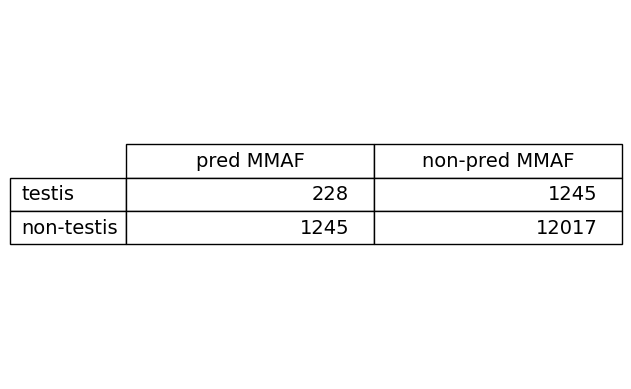

In [29]:
# plot the contingency table

# sanity check for parameters:
print(f"phenotype = {PHENOTYPE}")
print(f"alpha = {ALPHA}")
print(f"d_max = {D_MAX}")

print(f"PRED_{PHENOTYPE}_DEFINITION: Top {PRED_CAUSAL_DEFINITION}%")
print(f"{TISSUE}_DEFINITION: Top {TISSUE_DEFINITION}%")

# plot p-value fo the Fisher test
print(f"p-value = {pvalue_Fisher} (Fisher test)")

fig, ax = matplotlib.pyplot.subplots(1,1)
table = ax.table(contingency_matrix, rowLabels=[f'{TISSUE}', f'non-{TISSUE}'], colLabels=[f'pred {PHENOTYPE}', f'non-pred {PHENOTYPE}'], loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [30]:
proportion1 = x1 / (x1 + x3) # ratio of predicted causal genes that are tissue-enriched
proportion2 = x2 / (x2 + x4) # ratio of all genes that are tissue-enriched

In [31]:
def pvalue_to_stars(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return ""

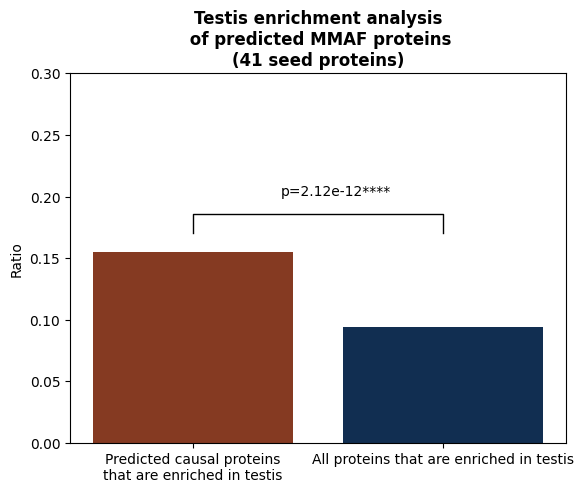

In [33]:
xticks = [f"Predicted causal proteins\nthat are enriched in {TISSUE}", 
          f"All proteins that are enriched in {TISSUE}"]

matplotlib.pyplot.bar(x=xticks, height=[proportion1, proportion2], color=['#853A22', '#112E51'])
matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted {PHENOTYPE} proteins\n({len(results_leave_one_out)} seed proteins)", weight='bold', fontsize=12)

# p-value significance
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

stars = pvalue_to_stars(pvalue=float(pvalue_Fisher))

matplotlib.pyplot.plot([xticks[0], xticks[0], xticks[1], xticks[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"p={pvalue_Fisher}{stars}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_tissue_enrichment", dpi=1000)

### Part III: Contributions to c_i and N_i at various distances

In [402]:
df_scores = pandas.DataFrame()
df_normFactors = pandas.DataFrame()

alpha = str(ALPHA).replace('.', '')

for d in range(1, 11):
    scores = numpy.load(f"{PATH_TO_CONTRIBUTIONS}/{PHENOTYPE}/scores_d{d}_alpha{alpha}_dmax{D_MAX}_alphanorm{ALPHA_NORM}.npz")["arr_0"]
    normFactors = numpy.load(f"{PATH_TO_CONTRIBUTIONS}/{PHENOTYPE}/normFactors_d{d}_alpha{alpha}_dmax{D_MAX}_alphanorm{ALPHA_NORM}.npz")["arr_0"]
    
    df_scores[f"d = {d}"] = scores

    df_normFactors[f"d = {d}"] = normFactors

NameError: name 'PATH_TO_CONTRIBUTIONS' is not defined

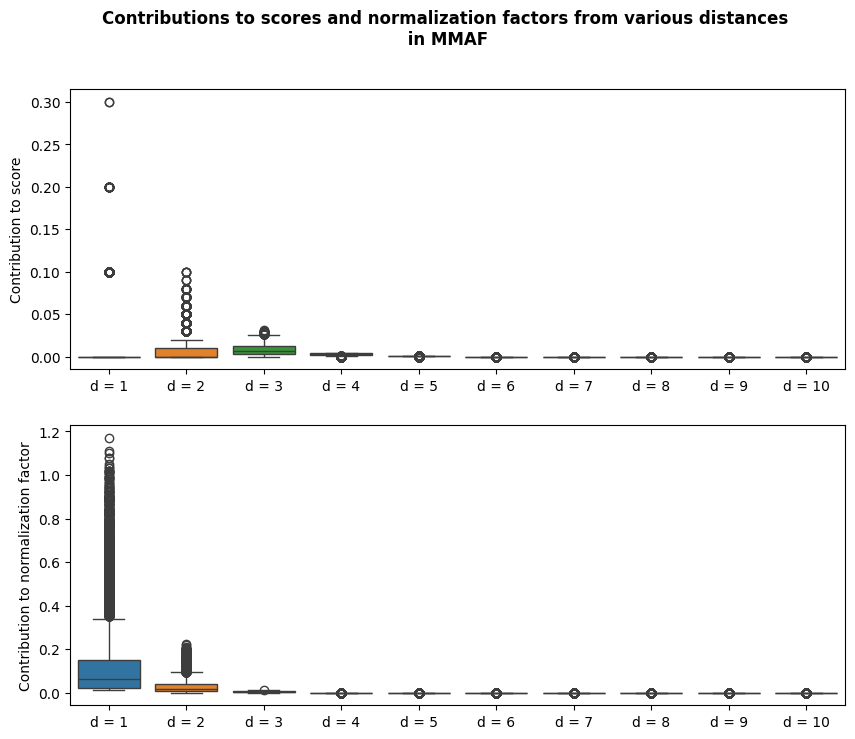

In [32]:
fig, ax = matplotlib.pyplot.subplots(2, 1, figsize=(10, 8))

# fig.suptitle(f"New centrality v8\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\n{PHENOTYPE}\nContributions to score")
fig.suptitle(f"Contributions to scores and normalization factors from various distances\n in {PHENOTYPE}", weight='bold')

seaborn.boxplot(data=df_scores, ax=ax[0])
ax[0].set_ylabel("Contribution to score")

seaborn.boxplot(data=df_normFactors, ax=ax[1])
ax[1].set_ylabel("Contribution to normalization factor")

matplotlib.pyplot.show()

### Part IV: Robustness

In [43]:
interactome_old = utils.parse_interactome(interactome_file=INTERACTOME_OLD_PATH)
len(interactome_old.nodes()), len(interactome_old.edges())

(14393, 89319)

In [44]:
results_old = parse_scores(RESULTS_OLD_PATH)

In [45]:
# get top PRED_CAUSAL_DEFINITION[%] of highest-scoring genes from New centrality
results_old_sorted = sorted(results_old.keys(), key=lambda item: results_old[item], reverse=True)

scores_old_sorted = [results_old[node] for node in results_old_sorted]

pred_causal_old, non_pred_causal_old = take_top_percent(results_old_sorted, PRED_CAUSAL_DEFINITION)

In [46]:
len(pred_causal_old), len(pred_causal)

(1439, 1473)

In [47]:
_, pvalue = scipy.stats.ranksums(pred_causal, pred_causal_old, alternative='two-sided')

In [48]:
pvalue

np.float64(0.5745716284741862)

In [49]:
len(intersection(pred_causal, pred_causal_old))

1365

In [55]:
x1 = len(pred_causal) - len(intersection(pred_causal, pred_causal_old))
x2 = len(pred_causal_old) - len(intersection(pred_causal, pred_causal_old))
x3 =  len(intersection(pred_causal, pred_causal_old))

Text(0.5, 1.0, 'The intersection of predicted causal proteins\n in old vs new interactome\nfor MMAF')

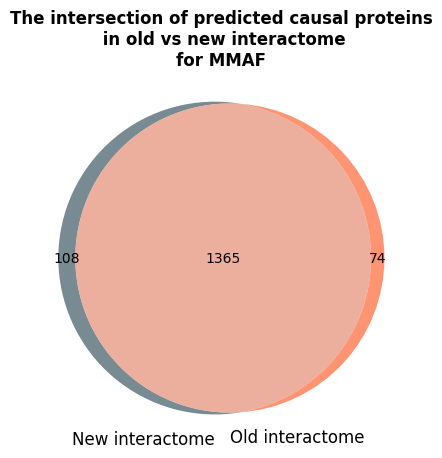

In [73]:
matplotlib_venn.venn2([x1, x2, x3], 
                      set_labels=("New interactome", "Old interactome"),
                      set_colors=("#4B636E", "#FF7043"), alpha=0.75)
matplotlib.pyplot.title(f"The intersection of predicted causal proteins\n in old vs new interactome\nfor {PHENOTYPE}", 
                        weight='bold',
                        fontsize=12)